In [3]:
%run Global.ipynb
%run Helper_Functions.ipynb

In [5]:
train_df_ohe_selected = pd.read_csv("./Final/Datasets/train_df_ohe.csv", keep_default_na=False)

X = train_df_ohe_selected.iloc[:,:-1] # (transformed) attributes
y = train_df_ohe_selected.iloc[:,-1]  # ground truth labels

In [16]:
# run in terminal: python -m pip install mlxtend
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#example-3-stacked-cv-classification-and-gridsearch
import mlxtend
from mlxtend.classifier import StackingCVClassifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Choosing Base classifiers

In [38]:
# multinomial NB
mnb = MultinomialNB()

# linear svm
linearSVM = svm.LinearSVC(random_state=30027, C=1)

# logr
logr = LogisticRegression(solver='sag', max_iter=100, random_state = 30027)

# decision tree
dt = DecisionTreeClassifier(max_depth = 400, random_state = 30027)

# knn
knn = KNeighborsClassifier(n_neighbors=3)

MultinomialNB prediction took 1.0461909770965576 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.699301    0.170358      0.273973       0.733769    0.969155   
1       0.716418    0.163543      0.266297       0.735376    0.977175   
2       0.744681    0.179181      0.288858       0.737407    0.975324   
3       0.739837    0.155290      0.256700       0.734043    0.979025   
4       0.741259    0.180887      0.290809       0.736351    0.973473   
5       0.711111    0.163823      0.266297       0.736105    0.972239   
6       0.715517    0.141638      0.236467       0.732531    0.976558   
7       0.731884    0.172355      0.279006       0.738239    0.977791   
8       0.729730    0.183986      0.293878       0.737015    0.972222   
9       0.732283    0.158433      0.260504       0.735007    0.975926   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.835194       0.521739    0.121212      0.196721  0.729519  

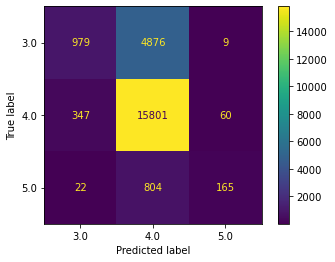

,mean,std
3.0_precision,0.726202,0.014896
3.0_recall,0.166949,0.013104
3.0_f1-score,0.271279,0.017821
4.0_precision,0.735584,0.001784
4.0_recall,0.974889,0.003052
4.0_f1-score,0.838494,0.001620
5.0_precision,0.708076,0.111015
5.0_recall,0.166525,0.035188
5.0_f1-score,0.268477,0.049839
accuracy,0.734727,0.002458


In [19]:
# MultinomialNB
mnb_pred, mnb_report = cross_val_report(mnb, X, y)
mnb_report

LinearSVC prediction took 44.23877811431885 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.725146    0.211244      0.327177       0.742135    0.960518   
1       0.732394    0.177172      0.285322       0.736867    0.969155   
2       0.701754    0.204778      0.317041       0.740161    0.962986   
3       0.718121    0.182594      0.291156       0.738006    0.967921   
4       0.737143    0.220137      0.339028       0.744175    0.965453   
5       0.687075    0.172355      0.275580       0.738084    0.964837   
6       0.744526    0.174061      0.282158       0.736572    0.972856   
7       0.732919    0.201365      0.315930       0.743371    0.968538   
8       0.791367    0.187394      0.303030       0.738195    0.974691   
9       0.726027    0.180579      0.289222       0.738432    0.965432   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.837322       0.447368    0.171717      0.248175  0.736021  
1   

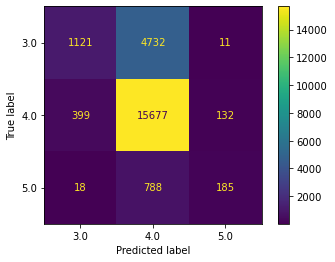

,mean,std
3.0_precision,0.729647,0.027612
3.0_recall,0.191168,0.016911
3.0_f1-score,0.302564,0.021275
4.0_precision,0.739600,0.002723
4.0_recall,0.967239,0.004326
4.0_f1-score,0.838230,0.001722
5.0_precision,0.565419,0.072234
5.0_recall,0.186737,0.036567
5.0_f1-score,0.279482,0.046498
accuracy,0.736374,0.003110


In [20]:
# linear SVM
svm_pred, svm_report = cross_val_report(linearSVM, X, y)
svm_report

LogisticRegression prediction took 187.81704878807068 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.718121    0.182283      0.290761       0.733395    0.974090   
1       0.705036    0.166951      0.269972       0.732159    0.974707   
2       0.675676    0.170648      0.272480       0.731753    0.971006   
3       0.691176    0.160410      0.260388       0.731447    0.972856   
4       0.773723    0.180887      0.293223       0.734722    0.979025   
5       0.650794    0.139932      0.230337       0.727357    0.971006   
6       0.739496    0.150171      0.249645       0.730699    0.980876   
7       0.730769    0.162116      0.265363       0.731764    0.977791   
8       0.737931    0.182283      0.292350       0.734201    0.975309   
9       0.695652    0.163543      0.264828       0.731572    0.974074   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.836778       0.800000    0.040404      0.076923  0.732

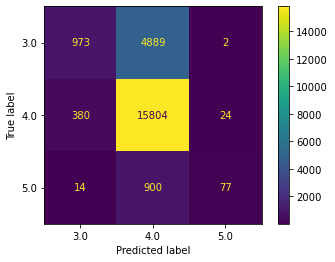

,mean,std
3.0_precision,0.711837,0.035657
3.0_recall,0.165922,0.013972
3.0_f1-score,0.268935,0.019980
4.0_precision,0.731907,0.002055
4.0_recall,0.975074,0.003280
4.0_f1-score,0.836168,0.002118
5.0_precision,0.756117,0.091926
5.0_recall,0.077717,0.021376
5.0_f1-score,0.140022,0.035440
accuracy,0.730781,0.003825


In [39]:
# logistic regression
logr_pred, logr_report = cross_val_report(logr, X, y)
logr_report

DecisionTreeClassifier prediction took 20.36279821395874 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.345572    0.272572      0.304762       0.726251    0.797039   
1       0.387387    0.293015      0.333657       0.736203    0.822949   
2       0.376777    0.271331      0.315476       0.730853    0.824183   
3       0.375271    0.295222      0.330468       0.734899    0.810611   
4       0.356979    0.266212      0.304985       0.732488    0.819247   
5       0.344988    0.252560      0.291626       0.723640    0.804442   
6       0.347926    0.257679      0.296078       0.722652    0.806909   
7       0.348454    0.288396      0.315593       0.729072    0.795188   
8       0.331111    0.253833      0.287367       0.721729    0.803704   
9       0.329694    0.257240      0.288995       0.719485    0.793210   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.760000       0.292308    0.191919      0.231707  0.

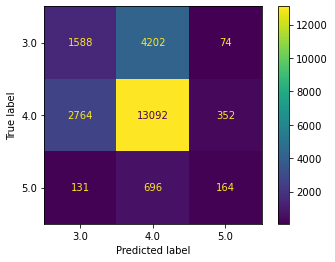

,mean,std
3.0_precision,0.354416,0.019515
3.0_recall,0.270806,0.016332
3.0_f1-score,0.306901,0.016604
4.0_precision,0.727727,0.005832
4.0_recall,0.807748,0.011320
4.0_f1-score,0.765635,0.007698
5.0_precision,0.277622,0.030422
5.0_recall,0.165525,0.029217
5.0_f1-score,0.206740,0.029105
accuracy,0.643627,0.009075


In [22]:
# decision tree
dt_pred, dt_report = cross_val_report(dt, X, y)
dt_report

KNeighborsClassifier prediction took 12.36660885810852 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.293194    0.190801      0.231166       0.709138    0.837754   
1       0.319202    0.218058      0.259109       0.717678    0.838988   
2       0.308511    0.197952      0.241164       0.714583    0.846391   
3       0.293506    0.192833      0.232750       0.714435    0.842690   
4       0.277228    0.191126      0.226263       0.708928    0.827884   
5       0.315650    0.203072      0.247144       0.716597    0.847008   
6       0.279597    0.189420      0.225839       0.709627    0.832202   
7       0.319905    0.230375      0.267857       0.716498    0.827884   
8       0.279597    0.189097      0.225610       0.711427    0.833951   
9       0.296675    0.197615      0.237219       0.711802    0.833951   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.768100       0.000000    0.000000      0.000000  0.63

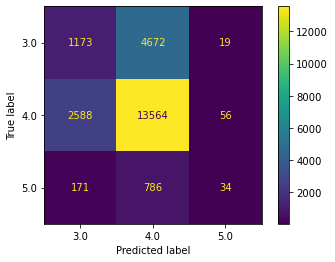

,mean,std
3.0_precision,0.298306,0.016681
3.0_recall,0.200035,0.013799
3.0_f1-score,0.239412,0.014624
4.0_precision,0.713071,0.003306
4.0_recall,0.836870,0.006935
4.0_f1-score,0.770017,0.004190
5.0_precision,0.304024,0.147853
5.0_recall,0.034323,0.019764
5.0_f1-score,0.061397,0.034426
accuracy,0.640463,0.006022


In [23]:
# knn
knn_pred, knn_report = cross_val_report(knn, X, y)
knn_report

## 5 Base Classifiers

In [40]:
sclf5 = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt, knn], 
                            meta_classifier=LogisticRegression(random_state = 30027),
                            cv = 2,
                            random_state=30027)

StackingCVClassifier prediction took 586.324718952179 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.710692    0.192504      0.302949       0.733706    0.972239   
1       0.714286    0.170358      0.275103       0.730840    0.976558   
2       0.739437    0.179181      0.288462       0.732902    0.978408   
3       0.763359    0.170648      0.278940       0.732628    0.982110   
4       0.754967    0.194539      0.309362       0.735035    0.977175   
5       0.716312    0.172355      0.277854       0.735102    0.974090   
6       0.743590    0.148464      0.247511       0.727023    0.980876   
7       0.750000    0.189420      0.302452       0.736085    0.979025   
8       0.785714    0.187394      0.302613       0.735403    0.979630   
9       0.737226    0.172061      0.279006       0.732564    0.979012   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.836296       0.000000    0.000000      0.000000  0.732

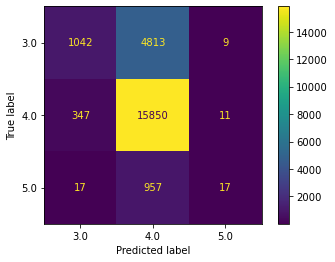

,mean,std
3.0_precision,0.741558,0.023658
3.0_recall,0.177692,0.013964
3.0_f1-score,0.286425,0.018706
4.0_precision,0.733129,0.002686
4.0_recall,0.977912,0.003004
4.0_f1-score,0.838006,0.001759
5.0_precision,0.452941,0.438269
5.0_recall,0.017172,0.027374
5.0_f1-score,0.031302,0.046807
accuracy,0.733166,0.002958


In [41]:
y_pred5, sclf5_report = cross_val_report(sclf5, X, y)
sclf5_report

## 4 Base Classifiers

### remove kNN

StackingCVClassifier prediction took 506.8848090171814 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.729032    0.192504      0.304582       0.737213    0.969155   
1       0.726619    0.172061      0.278237       0.735734    0.970389   
2       0.751773    0.180887      0.291609       0.736156    0.975941   
3       0.733813    0.174061      0.281379       0.735691    0.975324   
4       0.774648    0.187713      0.302198       0.737209    0.977791   
5       0.730496    0.175768      0.283356       0.738195    0.974090   
6       0.745902    0.155290      0.257062       0.733025    0.979025   
7       0.770833    0.189420      0.304110       0.741017    0.979642   
8       0.789855    0.185690      0.300690       0.736427    0.979630   
9       0.726027    0.180579      0.289222       0.737850    0.974691   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.837420       0.476190    0.101010      0.166667  0.73

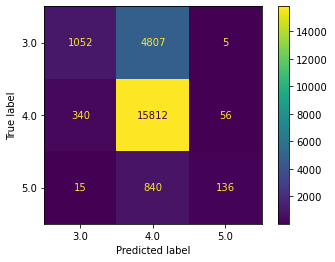

,mean,std
3.0_precision,0.747900,0.023116
3.0_recall,0.179397,0.010859
3.0_f1-score,0.289245,0.014959
4.0_precision,0.736852,0.002063
4.0_recall,0.975568,0.003668
4.0_f1-score,0.839567,0.001958
5.0_precision,0.689719,0.120869
5.0_recall,0.137283,0.042488
5.0_f1-score,0.227178,0.062595
accuracy,0.737112,0.002908


In [42]:
sclf_knn = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt], 
                            meta_classifier=LogisticRegression(random_state = 30027),
                            cv = 2,
                            random_state=30027)
y_pred_knn, sclf_knn_report = cross_val_report(sclf_knn, X, y)
sclf_knn_report

### remove decision tree

StackingCVClassifier prediction took 482.11352491378784 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.734568    0.202726      0.317757       0.735884    0.972856   
1       0.732394    0.177172      0.285322       0.731640    0.977175   
2       0.739437    0.179181      0.288462       0.736351    0.973473   
3       0.733813    0.174061      0.281379       0.735691    0.975324   
4       0.763975    0.209898      0.329317       0.738684    0.976558   
5       0.686131    0.160410      0.260028       0.734827    0.971006   
6       0.746032    0.160410      0.264045       0.733796    0.977791   
7       0.776978    0.184300      0.297931       0.740326    0.979642   
8       0.739726    0.183986      0.294679       0.735322    0.974074   
9       0.726027    0.180579      0.289222       0.736351    0.974074   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.837938       0.000000    0.000000      0.000000  0.7

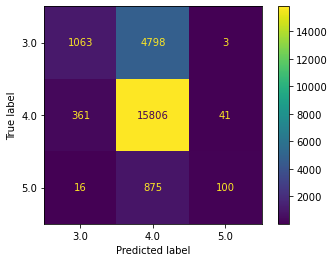

,mean,std
3.0_precision,0.737908,0.023940
3.0_recall,0.181272,0.015777
3.0_f1-score,0.290814,0.021254
4.0_precision,0.735887,0.002400
4.0_recall,0.975197,0.002599
4.0_f1-score,0.838805,0.002020
5.0_precision,0.588116,0.332202
5.0_recall,0.100889,0.072020
5.0_f1-score,0.167542,0.116052
accuracy,0.735767,0.003369


In [43]:
sclf_dt = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, knn], 
                            meta_classifier=LogisticRegression(random_state = 30027),
                            cv = 2,
                            random_state=30027)
y_pred_dt, sclf_dt_report = cross_val_report(sclf_dt, X, y)
sclf_dt_report

## 3 Base Classifiers

StackingCVClassifier prediction took 434.00854086875916 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.706587    0.201022      0.312997       0.738208    0.965453   
1       0.748092    0.166951      0.272981       0.734722    0.979025   
2       0.701754    0.204778      0.317041       0.739028    0.966070   
3       0.733813    0.174061      0.281379       0.735691    0.975324   
4       0.769231    0.204778      0.323450       0.740515    0.975324   
5       0.731343    0.167235      0.272222       0.736376    0.975324   
6       0.737705    0.153584      0.254237       0.732564    0.978408   
7       0.765101    0.194539      0.310204       0.741815    0.978408   
8       0.791367    0.187394      0.303030       0.737111    0.979630   
9       0.726027    0.180579      0.289222       0.737828    0.972840   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.836675       0.500000    0.101010      0.168067  0.7

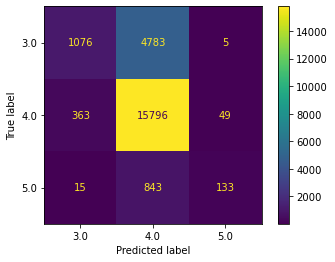

,mean,std
3.0_precision,0.741102,0.028026
3.0_recall,0.183492,0.017890
3.0_f1-score,0.293676,0.023049
4.0_precision,0.737386,0.002734
4.0_recall,0.974581,0.005110
4.0_f1-score,0.839542,0.002193
5.0_precision,0.711663,0.125478
5.0_recall,0.134253,0.034482
5.0_f1-score,0.224902,0.052759
accuracy,0.737328,0.003484


In [44]:
# remove both kNN and decision tree
sclf3 = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=LogisticRegression(random_state = 30027),
                            cv = 2,
                            random_state=30027)
y_pred3, sclf3_report = cross_val_report(sclf3, X, y)
sclf3_report

# Choosing Metaclassifier

============================== Logistic regression ==============================
StackingCVClassifier prediction took 436.595978975296 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.706587    0.201022      0.312997       0.738208    0.965453   
1       0.748092    0.166951      0.272981       0.734722    0.979025   
2       0.701754    0.204778      0.317041       0.739028    0.966070   
3       0.733813    0.174061      0.281379       0.735691    0.975324   
4       0.769231    0.204778      0.323450       0.740515    0.975324   
5       0.731343    0.167235      0.272222       0.736376    0.975324   
6       0.737705    0.153584      0.254237       0.732564    0.978408   
7       0.765101    0.194539      0.310204       0.741815    0.978408   
8       0.791367    0.187394      0.303030       0.737111    0.979630   
9       0.726027    0.180579      0.289222       0.737828    0.972840   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1

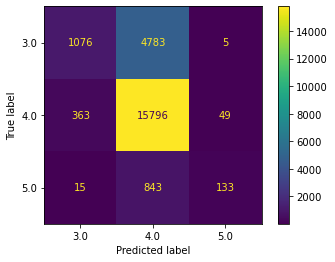

                   mean       std
3.0_precision  0.741102  0.028026
3.0_recall     0.183492  0.017890
3.0_f1-score   0.293676  0.023049
4.0_precision  0.737386  0.002734
4.0_recall     0.974581  0.005110
4.0_f1-score   0.839542  0.002193
5.0_precision  0.711663  0.125478
5.0_recall     0.134253  0.034482
5.0_f1-score   0.224902  0.052759
accuracy       0.737328  0.003484

============================== Categorical naive bayes ==============================
StackingCVClassifier prediction took 443.9157090187073 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.701087    0.219761      0.334630       0.743639    0.955583   
1       0.691358    0.190801      0.299065       0.740389    0.962369   
2       0.689266    0.208191      0.319790       0.742721    0.959901   
3       0.692771    0.196246      0.305851       0.740864    0.962986   
4       0.723757    0.223549      0.341591       0.745455    0.961135   
5       0.683230    0.187713      0.

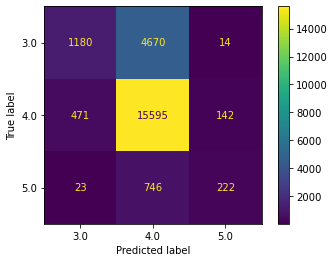

                   mean       std
3.0_precision  0.705137  0.016822
3.0_recall     0.201227  0.013148
3.0_f1-score   0.312887  0.016151
4.0_precision  0.742235  0.001515
4.0_recall     0.962179  0.003679
4.0_f1-score   0.838011  0.001319
5.0_precision  0.587615  0.067444
5.0_recall     0.224051  0.034477
5.0_f1-score   0.323771  0.044102
accuracy       0.736981  0.002263



In [45]:
sclf = sclf3 # the best base classifiers
meta_clfs = {"Logistic regression": LogisticRegression(random_state = 30027), "Categorical naive bayes": CategoricalNB()}
predictions = {}
reports = {}
for name, meta_clf in meta_clfs.items(): 
    sclf.meta_classifier = meta_clf
    print(f'============================== {name} ==============================')
    predictions[name], reports[name] = cross_val_report(sclf3, X, y)
    print(reports[name])
    print('\n\n')

## Hyperparameter Tuning

### Meta classifier = CategoricalNB

In [47]:
sclf3.get_params()

{'classifiers': [MultinomialNB(),
  LinearSVC(C=1, random_state=30027),
  LogisticRegression(random_state=30027, solver='sag')],
 'cv': 2,
 'drop_proba_col': None,
 'meta_classifier__alpha': 1.0,
 'meta_classifier__class_prior': None,
 'meta_classifier__fit_prior': True,
 'meta_classifier__force_alpha': 'warn',
 'meta_classifier__min_categories': None,
 'meta_classifier': CategoricalNB(),
 'n_jobs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': 30027,
 'shuffle': True,
 'store_train_meta_features': False,
 'stratify': True,
 'use_clones': True,
 'use_features_in_secondary': False,
 'use_probas': False,
 'verbose': 0,
 'multinomialnb': MultinomialNB(),
 'linearsvc': LinearSVC(C=1, random_state=30027),
 'logisticregression': LogisticRegression(random_state=30027, solver='sag'),
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True,
 'multinomialnb__force_alpha': 'warn',
 'linearsvc__C': 1,
 'linearsvc__class_weight': None,
 'linearsvc_

In [54]:
param_grid = {'linearsvc__C': [1,3,5], 'multinomialnb__alpha': [0.1, 0.3, 0.5, 0.7, 1], 'logisticregression__max_iter': [50, 100, 150]}
sclf3.meta_classifier = CategoricalNB()
grid_cat = tune_hyperparameter(sclf3, param_grid, X, y, cv=2)

Fitting 2 folds for each of 45 candidates, totalling 90 fits
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.1; total time=  15.6s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.1; total time=  14.5s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.3; total time=  13.1s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.3; total time=  14.7s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.5; total time=  16.0s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.5; total time=  14.0s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.7; total time=  15.4s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.7; total time=  13.7s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=1; total time=  13.1s
[CV] END linea

[CV] END linearsvc__C=5, logisticregression__max_iter=100, multinomialnb__alpha=1; total time=  23.0s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.1; total time=  31.9s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.1; total time=  36.0s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.3; total time=  33.6s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.3; total time=  38.1s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.5; total time=  32.2s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.5; total time=  32.0s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.7; total time=  32.2s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.7; total time=  33.8s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multino

In [60]:
r = re.compile('(^(rank_test).*(f1-score|accuracy)$)|(mean_test_accuracy)|(params)')
score_metrics = list(filter(r.match, grid_cat.columns))
grid_cat[score_metrics]

,params,rank_test_3.0_f1-score,rank_test_4.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,"{'linearsvc__C': 1, 'logisticregression__max_i...",31,15,7,0.732255,13
1,"{'linearsvc__C': 1, 'logisticregression__max_i...",34,10,16,0.732775,5
2,"{'linearsvc__C': 1, 'logisticregression__max_i...",37,12,31,0.732559,11
3,"{'linearsvc__C': 1, 'logisticregression__max_i...",39,6,42,0.732732,7
4,"{'linearsvc__C': 1, 'logisticregression__max_i...",43,3,45,0.732992,3
5,"{'linearsvc__C': 1, 'logisticregression__max_i...",33,14,7,0.732212,15
6,"{'linearsvc__C': 1, 'logisticregression__max_i...",36,9,16,0.732732,8
7,"{'linearsvc__C': 1, 'logisticregression__max_i...",40,11,31,0.732515,12
8,"{'linearsvc__C': 1, 'logisticregression__max_i...",42,5,39,0.732732,9
9,"{'linearsvc__C': 1, 'logisticregression__max_i...",45,2,44,0.733036,2


In [61]:
print(max(grid_cat['mean_test_accuracy']))
grid_cat.loc[grid_cat['mean_test_accuracy'] == max(grid_cat['mean_test_accuracy'])]['params'].values

0.7331656347622313


array([{'linearsvc__C': 1, 'logisticregression__max_iter': 150, 'multinomialnb__alpha': 1}],
      dtype=object)

StackingCVClassifier prediction took 572.0949230194092 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.701087    0.219761      0.334630       0.743639    0.955583   
1       0.691358    0.190801      0.299065       0.740389    0.962369   
2       0.689266    0.208191      0.319790       0.742721    0.959901   
3       0.692771    0.196246      0.305851       0.740864    0.962986   
4       0.723757    0.223549      0.341591       0.745455    0.961135   
5       0.687500    0.187713      0.294906       0.741552    0.961135   
6       0.734694    0.184300      0.294679       0.741282    0.970389   
7       0.704142    0.203072      0.315232       0.743102    0.963603   
8       0.718563    0.204429      0.318302       0.741797    0.962963   
9       0.712500    0.194208      0.305221       0.741004    0.966049   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.836393       0.475000    0.191919      0.273381  0.73

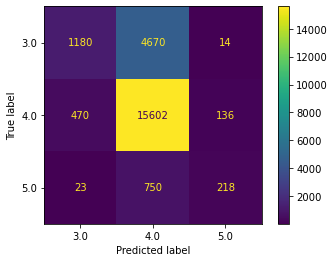

,mean,std
3.0_precision,0.705564,0.016248
3.0_recall,0.201227,0.013148
3.0_f1-score,0.312927,0.016101
4.0_precision,0.742180,0.001551
4.0_recall,0.962611,0.003869
4.0_f1-score,0.838140,0.001316
5.0_precision,0.591691,0.063811
5.0_recall,0.220010,0.034452
5.0_f1-score,0.320241,0.044042
accuracy,0.737112,0.002204


In [64]:
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(random_state=30027, C=1)
logr = LogisticRegression(solver='sag', max_iter=150, random_state = 30027)

sclf3_cat = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
y_pred3_cat, sclf3_cat_report = cross_val_report(sclf3_cat, X, y)
sclf3_cat_report

### Meta classifier = LogisticRegression

In [65]:
param_grid = {'linearsvc__C': [1,3,5], 'multinomialnb__alpha': [0.1, 0.3, 0.5, 0.7, 1], 'logisticregression__max_iter': [50, 100, 150]}
sclf3.meta_classifier = LogisticRegression(random_state = 30027)
grid_logr = tune_hyperparameter(sclf3, param_grid, X, y, cv=2)


Fitting 2 folds for each of 45 candidates, totalling 90 fits
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.1; total time=  13.2s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.1; total time=27.5min
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.3; total time=  24.6s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.3; total time=  13.5s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.5; total time=  14.0s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.5; total time=  13.6s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.7; total time=  13.6s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.7; total time=  13.4s
[CV] END linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=1; total time=  13.7s
[CV] END linea

[CV] END linearsvc__C=5, logisticregression__max_iter=100, multinomialnb__alpha=1; total time=  22.3s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.1; total time=  31.5s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.1; total time=  31.6s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.3; total time=  32.5s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.3; total time=  31.5s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.5; total time=  34.1s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.5; total time=  32.4s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.7; total time=  35.4s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multinomialnb__alpha=0.7; total time=  35.3s
[CV] END linearsvc__C=5, logisticregression__max_iter=150, multino

In [66]:
r = re.compile('(^(rank_test).*(f1-score|accuracy)$)|(mean_test_accuracy)|(params)')
score_metrics = list(filter(r.match, grid_logr.columns))
grid_logr[score_metrics]

,params,rank_test_3.0_f1-score,rank_test_4.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,"{'linearsvc__C': 1, 'logisticregression__max_i...",27,25,28,0.730347,26
1,"{'linearsvc__C': 1, 'logisticregression__max_i...",30,20,31,0.730347,27
2,"{'linearsvc__C': 1, 'logisticregression__max_i...",34,14,5,0.730651,15
3,"{'linearsvc__C': 1, 'logisticregression__max_i...",29,3,9,0.731344,3
4,"{'linearsvc__C': 1, 'logisticregression__max_i...",36,37,45,0.729263,44
5,"{'linearsvc__C': 1, 'logisticregression__max_i...",40,40,17,0.729784,38
6,"{'linearsvc__C': 1, 'logisticregression__max_i...",19,5,22,0.731084,6
7,"{'linearsvc__C': 1, 'logisticregression__max_i...",35,10,3,0.730738,14
8,"{'linearsvc__C': 1, 'logisticregression__max_i...",44,36,7,0.729653,39
9,"{'linearsvc__C': 1, 'logisticregression__max_i...",42,1,35,0.730304,31


In [67]:
print(max(grid_logr['mean_test_accuracy']))
grid_logr.loc[grid_logr['mean_test_accuracy'] == max(grid_logr['mean_test_accuracy'])]['params'].values

0.7314745900695746


array([{'linearsvc__C': 5, 'logisticregression__max_iter': 150, 'multinomialnb__alpha': 0.5}],
      dtype=object)

StackingCVClassifier prediction took 568.1727550029755 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.702857    0.209540      0.322835       0.741305    0.959901   
1       0.284836    0.947189      0.437968       0.844985    0.171499   
2       0.680473    0.196246      0.304636       0.737016    0.962986   
3       0.752000    0.160410      0.264416       0.734230    0.976558   
4       0.757143    0.180887      0.292011       0.736351    0.973473   
5       0.686275    0.179181      0.284168       0.737882    0.967304   
6       0.732759    0.145051      0.242165       0.728022    0.980876   
7       0.800000    0.163823      0.271955       0.736574    0.981493   
8       0.769784    0.182283      0.294766       0.735911    0.975309   
9       0.737705    0.153322      0.253879       0.730575    0.980864   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.836559       0.484848    0.161616      0.242424  0.73

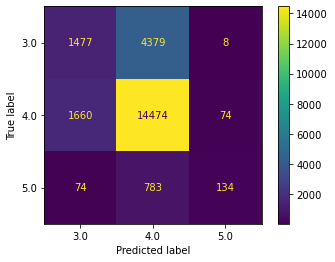

,mean,std
3.0_precision,0.690383,0.147327
3.0_recall,0.251793,0.245121
3.0_f1-score,0.296880,0.055123
4.0_precision,0.746285,0.034880
4.0_recall,0.893026,0.253632
4.0_f1-score,0.782413,0.174738
5.0_precision,0.649256,0.158785
5.0_recall,0.135263,0.053365
5.0_f1-score,0.218071,0.076949
accuracy,0.697449,0.115188


In [69]:
mnb = MultinomialNB(alpha = 0.5)
linearSVM = svm.LinearSVC(random_state=30027, C=5)
logr = LogisticRegression(solver='sag', max_iter=150, random_state = 30027)

sclf3_logr = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=LogisticRegression(random_state = 30027),
                            cv = 2,
                            random_state=30027)
y_pred3_logr, sclf3_logr_report = cross_val_report(sclf3_logr, X, y)
sclf3_logr_report

## Feature Selection

In [70]:
x2 = SelectKBest(chi2, k='all')
x2.fit(X, y)
pvals = pd.DataFrame(x2.pvalues_, index=x2.feature_names_in_, columns=['p-value'])

x2_features = pvals[pvals['p-value'] < 0.01].index.tolist()
x2_features.remove('PublishDay')

StackingCVClassifier prediction took 121.89364004135132 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.689655    0.136286      0.227596       0.729254    0.970389   
1       0.672131    0.139693      0.231312       0.731594    0.968538   
2       0.660550    0.122867      0.207194       0.726141    0.971622   
3       0.603960    0.104096      0.177584       0.724344    0.971006   
4       0.724138    0.143345      0.239316       0.730431    0.972856   
5       0.663636    0.124573      0.209770       0.729466    0.969772   
6       0.760417    0.124573      0.214076       0.730363    0.980876   
7       0.721649    0.119454      0.204978       0.728985    0.979025   
8       0.691667    0.141397      0.234795       0.730734    0.971605   
9       0.692308    0.122658      0.208394       0.728538    0.969136   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.832716       0.558824    0.191919      0.285714  0.7

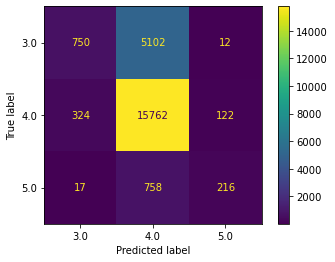

,mean,std
3.0_precision,0.688011,0.042660
3.0_recall,0.127894,0.012216
3.0_f1-score,0.215501,0.018374
4.0_precision,0.728985,0.002211
4.0_recall,0.972482,0.004158
4.0_f1-score,0.833306,0.002213
5.0_precision,0.619504,0.065686
5.0_recall,0.218010,0.035631
5.0_f1-score,0.321243,0.043576
accuracy,0.725318,0.004111


In [71]:
X_filtered = X[x2_features]
y_pred_filtered, sclf_filtered_report = cross_val_report(sclf3_cat, X_filtered, y)
sclf_filtered_report

StackingCVClassifier prediction took 188.4974489212036 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.722772    0.124361      0.212209       0.726606    0.977175   
1       0.700935    0.127768      0.216138       0.728236    0.975324   
2       0.673267    0.116041      0.197962       0.723239    0.975324   
3       0.662791    0.097270      0.169643       0.721893    0.978408   
4       0.732673    0.126280      0.215429       0.726109    0.979642   
5       0.696629    0.105802      0.183704       0.724532    0.978408   
6       0.814815    0.112628      0.197901       0.726860    0.988279   
7       0.730337    0.110922      0.192593       0.726734    0.982727   
8       0.722222    0.132879      0.224460       0.726731    0.978395   
9       0.726316    0.117547      0.202346       0.726939    0.977778   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.833465       0.538462    0.141414      0.224000  0.72

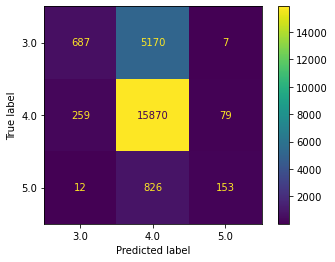

,mean,std
3.0_precision,0.718276,0.041695
3.0_recall,0.117150,0.010955
3.0_f1-score,0.201239,0.016622
4.0_precision,0.725788,0.001951
4.0_recall,0.979146,0.003846
4.0_f1-score,0.833639,0.002077
5.0_precision,0.641238,0.086965
5.0_recall,0.154444,0.036446
5.0_f1-score,0.247427,0.050837
accuracy,0.724537,0.003608


In [72]:
x2_features += ['PublishDay']
X_filtered = X[x2_features]
y_pred, sclf_report = cross_val_report(sclf, X_filtered, y)
sclf_report

## Test set prediction

In [91]:
X_features = list(X.columns)

In [92]:
X_features.remove('PublishDay')
X_features

['PublishYear',
 'PublishMonth',
 'pagesNumber',
 'gay_lesbian',
 'twentieth_century',
 'st_century',
 'united_state',
 'new_york',
 'th_century',
 'survival_guide',
 'around_world',
 'world_war',
 'war_ii',
 'civil_war',
 'essential_guide',
 'old_testament',
 'complete_guide',
 'field_guide',
 'african_american',
 'selected_poem',
 'fairy_tale',
 'de_la',
 'complete_idiot',
 'idiot_guide',
 'star_war',
 'science_fiction',
 'berenstain_bear',
 'american_history',
 'practical_guide',
 'study_guide',
 'true_story',
 'short_story',
 'cultural_history',
 'rough_guide',
 'need_know',
 'step_step',
 'theory_practice',
 'cambridge_companion',
 'cam_jansen',
 'new_world',
 'everyday_life',
 'choose_adventure',
 'nineteenth_century',
 'cold_war',
 'life_time',
 'middle_age',
 'holy_bible',
 'little_book',
 'life_death',
 'american_culture',
 'lonely_planet',
 'ultimate_guide',
 'new_testament',
 'br br',
 'br book',
 'life br',
 'new york',
 'york city',
 'year old',
 'year ago',
 'short story'

In [93]:
X_test = pd.read_csv("./Final/Datasets/test_df_ohe.csv", keep_default_na=False)[X_features]

In [94]:
def get_pred_df(y_pred):
    """
    Converts the list of predictions to a DataFrame with 2 columns (id, rating_label).
    Returns the resultant DataFrame.
    """
    
    pred_df = pd.DataFrame(y_pred).reset_index().set_axis(['id', 'rating_label'], axis=1)
    pred_df['id'] = pred_df['id']+1  # id starts from 1
    return pred_df

In [96]:
# selected feature set
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(random_state=30027, C=1)
logr = LogisticRegression(solver='sag', max_iter=150, random_state = 30027)

sclf3_cat = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)

if 'PublishDay' in x2_features: 
    x2_features.remove('PublishDay')
X_filtered = X[x2_features]
sclf3_cat.fit(X_filtered, y)
X_test_filtered = X_test[x2_features]
get_pred_df(sclf3_cat.predict(X_test_filtered)).to_csv("filtered_sclf3_cat_pred.csv", index=False)

In [97]:
# full feature set
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(random_state=30027, C=1)
logr = LogisticRegression(solver='sag', max_iter=150, random_state = 30027)

sclf3_cat = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
sclf3_cat.fit(X[X_features], y)
get_pred_df(sclf3_cat.predict(X_test)).to_csv("full_sclf3_cat_pred.csv", index=False)